# Computing image score
## Single image processing

In this part one will explain how to load a single tif image in python, and compute its bundling score.
- First, the image is loaded in python using `scikit-image`.
- Then, the image is cropped using the provided ROI. ROIs can be defined and exported on Fiji. Only squares are supported.
- Finally, the bundling score is computed using the function `compute_score`.
- We don't use picture metadata, so the score is given in $\textrm{px}^2$. One has to multiply by the square of the resolution to get it in $\mu \textrm{m}^2$.

The score of this image is 4.48e-01 um^2.


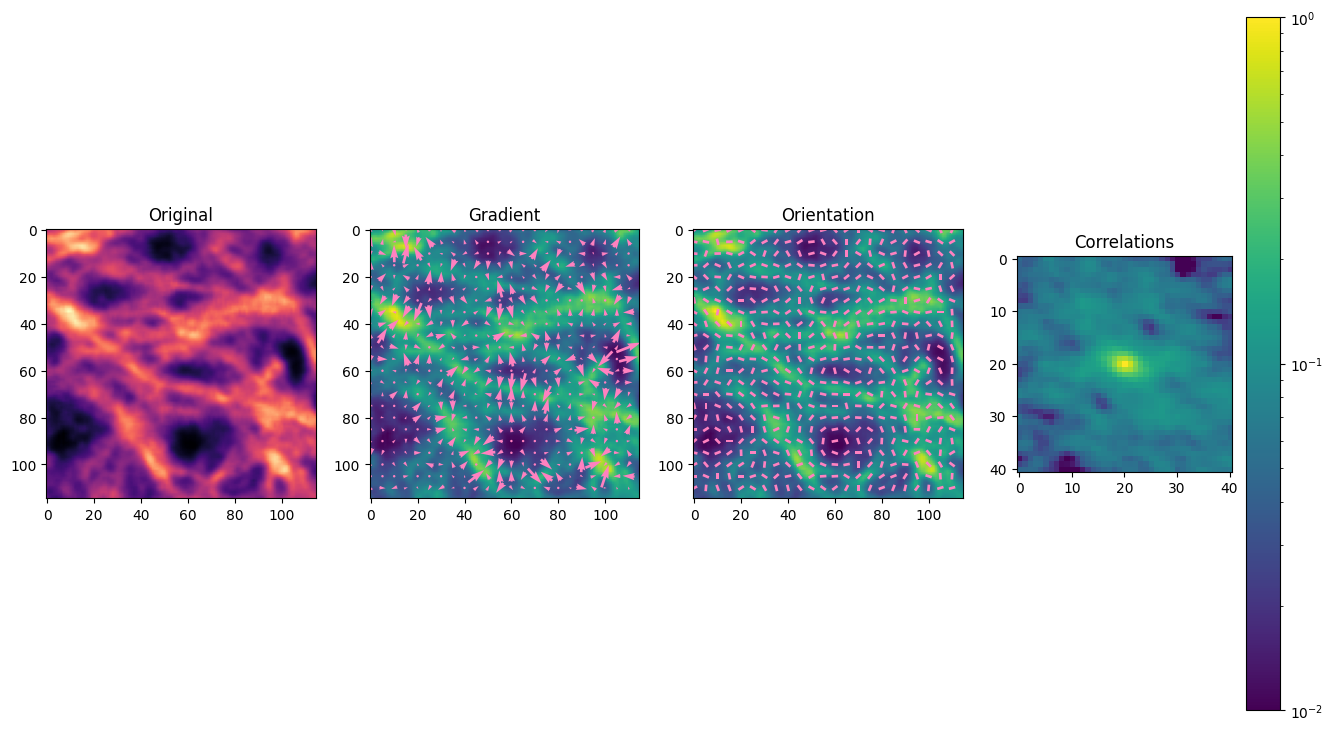

In [1]:
from skimage import io
from read_roi import read_roi_zip

import bundling_score.bundling_score as bs
import bundling_score.tools as bt
import bundling_score.plots as bp

example_file = 'img/cortex_single_image.tif'
roi_file = 'img/roi.tif.zip'

dx = 0.1 #um/px

# Load the image and the ROI
image = io.imread(example_file).astype(float)
roi = read_roi_zip(roi_file)

# Crop the image to keep only the ROI
image = bt.crop_fiji_roi(image, roi)
N = image.shape[0]
image = image[N//4:3*N//4, N//4:3*N//4]

# Compute the bundling score
score = bs.compute_score(image, smax=10)
print(f"The score of this image is {score*dx**2:.2e} um^2.")

bp.show_steps(image, smax=20,step=5)

## Timelapse processing
A timelapse can be processed in the same way, storing all scores in a list for example.



(115, 115)


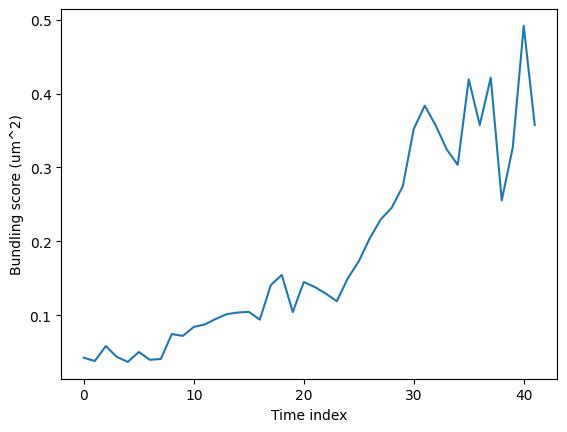

In [2]:
import matplotlib.pyplot as plt

example_file = 'img/cortex_timelapse.tif'
roi_file = 'img/roi.tif.zip'

dx = 0.1 #um/px

ic = io.MultiImage(example_file, dtype=float)
timelapse = ic[0] # Only one timelapse
roi = read_roi_zip(roi_file)
timelapse = bt.crop_fiji_roi(timelapse, roi)

scores = []
for i in range(timelapse.shape[0]):
    scores.append(bs.compute_score(timelapse[i, ...], smax=20)*dx**2)

plt.plot(scores)
plt.xlabel("Time index")
plt.ylabel("Bundling score (um^2)")
print(image.shape)

## Folder processing
Scikit-image image collection tools can be used to process a whole folder. In this example, all `tif` files in the `source` directory will be processed.

One uses `pandas` to create a DataFrame and create a csv file with headers.

   2021_12_15_2_GFP6-1  2021_12_15_2_GFP6-2
0             0.015818             0.020242
1             0.017228             0.022730
2             0.020303             0.032247
3             0.008818             0.039178
4             0.010787             0.061845


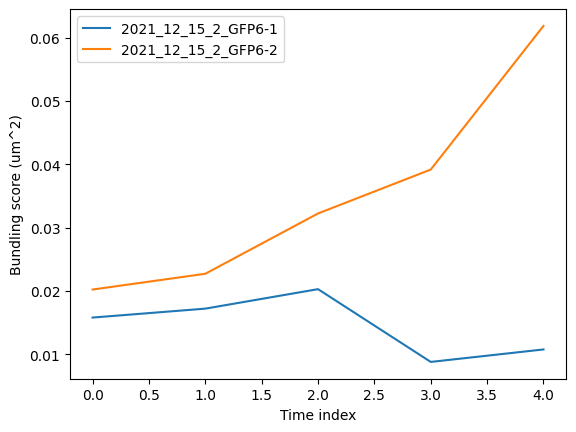

In [3]:
import pandas as pd

source_dir = 'img/source/'
ic = io.MultiImage(source_dir + '*.tif', dtype=float)

# Bundling scores will be stored in a DataFrame
df = pd.DataFrame()

for i, timelapse in enumerate(ic):
    # Get only the name of the file
    name = ic.files[i][len(source_dir):-4]
    # Load ROI and crop
    roi = read_roi_zip(source_dir+'sub_'+name+'.tif.zip')
    timelapse = timelapse.astype(float)
    timelapse = bt.crop_fiji_roi(timelapse, roi)
    
    scores = []
    
    for j in range(timelapse.shape[0]):
        scores.append(bs.compute_score(timelapse[j, ...], smax=20)*dx**2)
    plt.plot(scores, label=name)
    

    # Header is the name of the tif file
    series = pd.Series(scores, name=name)
    # Add to the main dataframe
    df = pd.concat((df, series), axis=1)

plt.legend()
plt.xlabel('Time index')
plt.ylabel('Bundling score (um^2)')

print(df)
# Save as csv
df.to_csv(source_dir + 'bundling_scores.csv')